## Time evolution of $\sigma_x$ and $\sigma_z$ at different $\alpha$ with fixed $\omega = 25.0$

run started!
time taken  40.358911752700806
code is okay!!


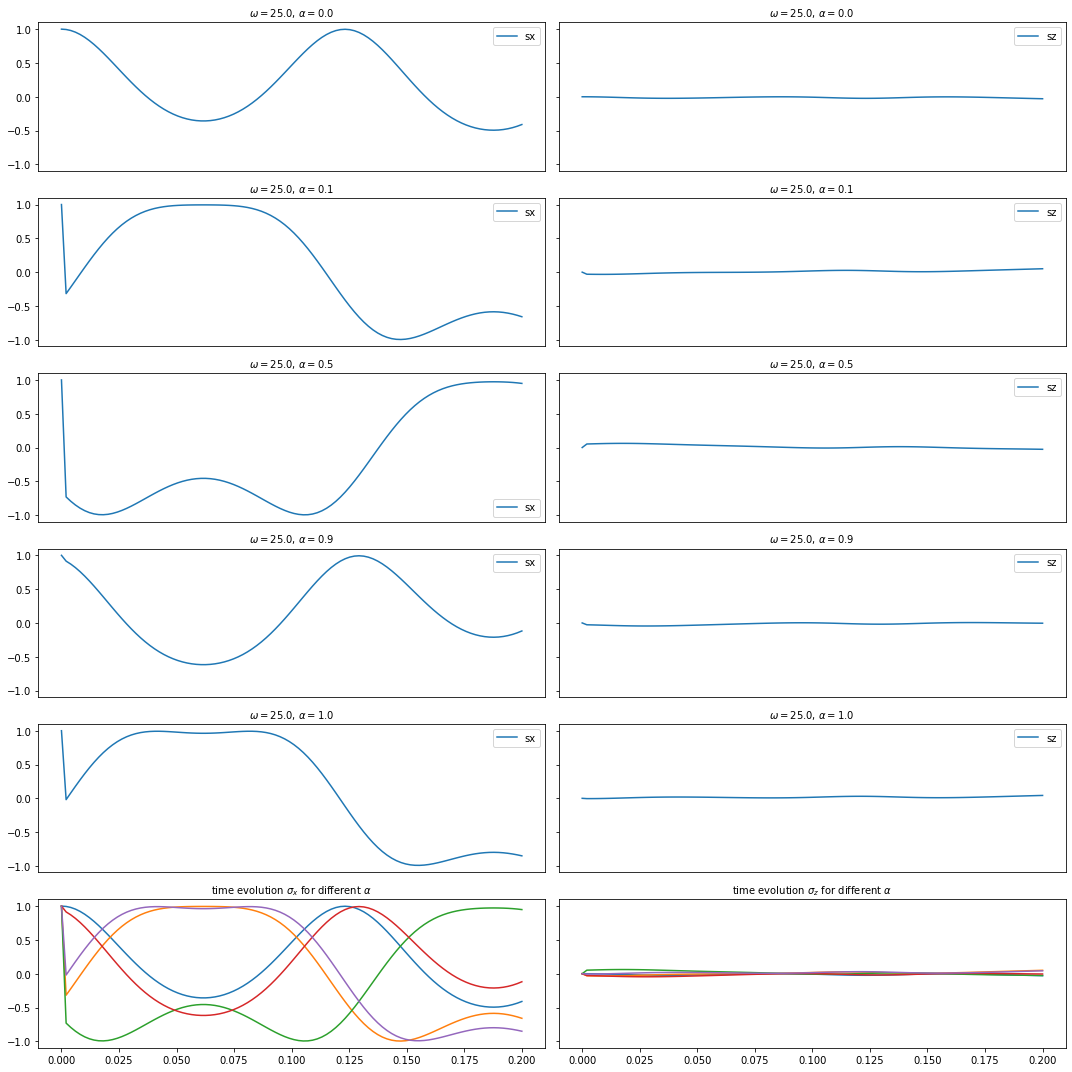

In [13]:
import numpy as np
from scipy.sparse import dia_matrix
from math import *
from itertools import combinations
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import time


start = time.time()

# Required parameters
N = 4           # Insert an integer value for N = no. of spin sites
alphas = [0.0, 0.1, 0.5, 0.9, 1.0]     # the number of order parameter; alpha = 0 is meanfield limit
omega = 25.0    # Insert a float value for omega
hdc = 0.1       # This is the dc part of the symmetry breaking field
amp = 25.0      # amplitude of the symmetry breaking field
n = 100         # Number of steps for odeint


#%matplotlib inline
#import matplotlib.pyplot as plt
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)
# fs = 15
#pheightmin = 10
fig, axs = plt.subplots(6,2, sharey=True, figsize=(15,15))
fs = 10
# Initial values: ACCORDING To XXZ model
jx, jy, jz = -1.0, 0.0, 0.0 
hx, hy, hz = 0.0, 0.0, -1.0 * amp

# Periodic Boundary Condition
def jmat(N, alpha):
    J = dia_matrix((N, N))
    mid_diag = np.floor(N/2).astype(int)
    for i in np.arange(1,mid_diag+1):
        elem = pow(i, -alpha)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    for i in np.arange(mid_diag+1, N):
        elem = pow(N-i, -alpha)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    return J.toarray()

def gcorr(G,t,k,a,b,wmat,gmat,v_vec,f_vec):
    left = sum(np.dot(wmat[a,c], gmat[k,c,b]) + np.dot(wmat[b,c], gmat[k,a,c]) for c in np.arange(3))
    mdl1 = v_vec[a] * sum(np.dot(J[0, j], gmat[np.absolute(j-k) + 1, b,0]) for j in np.arange(1,k))
    mdl2 = v_vec[b] * sum(np.dot(J[k, j], gmat[j,0,a]) for j in np.arange(1,k))
    rght = J[0, k] * (np.dot(v_vec[a], f_vec[b]) + np.dot(v_vec[b], f_vec[a]))
    gc   = (left + mdl1 + mdl2 + rght)
    return gc

def g_t(k,i,j,t,gstate,wmat,gmat,v_vec,f_vec):
    d_t = t
    a,b = i,j
    G = odeint(gcorr, gstate, d_t, args=((k,a,b,wmat,gmat,v_vec,f_vec)))
    gstate = G[1]
    return G[1]

def xxz_model(dxyz, tspan, gstate,ts):
    t = ts
    sx, sy, sz = dxyz[0], dxyz[1], dxyz[2]
    
    v_vec = np.array([[0.0], [ 2 * sz], [- 2 * sy]])
    f_vec = np.array([[1 - sx * sx], [- sy * sx], [- sz * sx]])
    hz1 = hz * np.cos(omega * t[1]) + hdc
    wmat = np.array([[0, 2 * hz1, 0], [- 2 * hz1, 0, 2 * (sx + hx)], [0, - 2 * (sx + hx), 0]])

    dsx = 2.0 * hz1 * sy
    # here t[1] is taken as in the odeint, the integration in limited in lower and upper boundary condition.
    # After each "Odeint" operation, the pointer or the programming courser goes to the final boundary condition.
    # which is t[1] here. Thats the reason I have taken time value as t[1] at the line bellow.
    dsy = 2.0 * sx * sz + 2.0 * hx * sz - 2.0 * hz1 * sx  + 2.0 * (sum(J[0,j] * g_t(j,0,2,t,gstate,wmat,gmat,v_vec,f_vec) for j in np.arange(1,N)))
    dsz = - 2.0 * sy * sx - 2.0 * hx * sy - 2.0 * sum(J[0,j] * g_t(j,0,1,t,gstate,wmat,gmat,v_vec,f_vec) for j in np.arange(1,N))

    dxyz = [dsx, dsy, dsz]   
    return dxyz

z0 = np.array([1.0, 0.0, 0.0], dtype=np.float64)  # Initial state
t = np.linspace(0.0, 0.2,n)
sx, sy, sz = np.zeros(n), np.zeros(n), np.zeros(n)
sx[0],sy[0],sz[0] = z0[0],z0[1],z0[2]
gstate = 0.0

gmat = np.zeros((N,3,3))
ttt = 0.0              #initialze the time as zero
wmat = np.array([[0, 2 * ( hz * np.cos(omega * ttt) + hdc), 0], \
                      [- 2 * (hz * np.cos(omega * ttt) +hdc), 0, 2 * (sx[0] + hx)],\
                      [0, - 2 * (sx[0] + hx), 0]])
v_vec = np.array([[0.0], [ 2 * sz[0]], [- 2 * sy[0]]])
f_vec = np.array([[1 - sx[0] * sx[0]], [- sy[0] * sx[0]], [- sz[0] * sx[0]]])

print("run started!")

for als, alph in enumerate(alphas):
    for i in range(1,n):
        
        J = jmat(N, alph)
        
        # as the odeint for coupled differential equation runs for single time interval due to its coupled behavior.
        tspan = [t[i-1],t[i]]
        ts = tspan
        # in args=((gstate, ts)) , ts is taken as argument, because odeint runs more interval than the time steps entered 
        # in the "odeint()" syntax. Like if I have entered the the time stpes= np.linspace(0,1,10), but in reality
        # it runs more steps in the "odeint" function when it runs. Thus is can cause ambiguity in the time steps I want
        # in other calculations in "xxz_model" function. So i have made "ts" as argumenmt.
        dxyz = odeint(xxz_model, z0, tspan, args=((gstate,ts)))
        sx[i], sy[i], sz[i] = dxyz[1][0], dxyz[1][1], dxyz[1][2]
        z0 = dxyz[1] 
        filename = 'bbgky_t_sx_sz_N4_w25p0_alpha' + str(alph) +'.txt'
    
    np.savetxt("filename",np.vstack((np.real(t), np.real(sx), np.real(sz))).T)
    
    axs[als, 0].set_title(r"$\omega = {}$, ".format(omega) + r"$\alpha = {}$ ".format(alph), fontsize=fs)
    axs[als, 0].plot(t,sx,label='sx')
    axs[als, 0].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    legend0 = axs[als, 0].legend(prop={'size': fs})
    
    axs[als, 1].set_title(r"$\omega = {}$, ".format(omega) + r"$\alpha = {}$ ".format(alph), fontsize=fs)
    axs[als, 1].plot(t,sz,label='sz')
    axs[als, 1].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    legend1 = axs[als, 1].legend(prop={'size': fs})
    
    axs[5, 0].set_title(r"time evolution $\sigma_x$ for different $\alpha$ ", fontsize=fs)
    axs[5, 0].plot(t,sx)
    axs[5, 1].set_title(r"time evolution $\sigma_z$ for different $\alpha$ ", fontsize=fs)
    axs[5, 1].plot(t,sz)
    fig.tight_layout()
    plt.plot()    
               
elapse= time.time() - start
print("time taken ", elapse)
print("code is okay!!")

### Time evolution of $\sigma_x and \sigma_z$ for different $\omega$ at Mean field limit, i.e. $\alpha=0.0$

run started!
time taken  2318.239405155182
code is okay!!


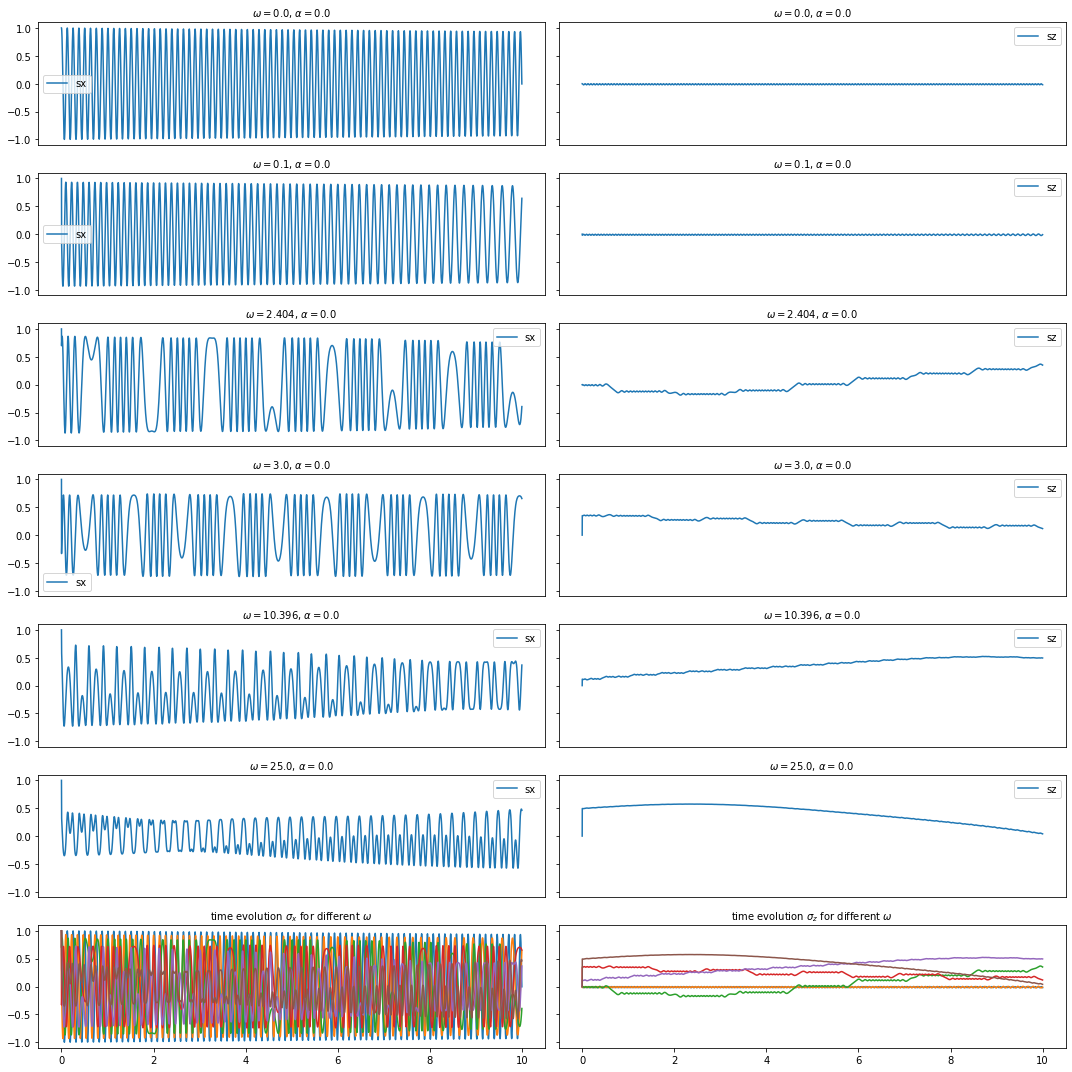

In [16]:
import numpy as np
from scipy.sparse import dia_matrix
from math import *
from itertools import combinations
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import time


start = time.time()

# Required parameters
N = 4           # Insert an integer value for N = no. of spin sites
alpha = 0.0     # the number of order parameter; alpha = 0 is meanfield limit
omegas = [0.0, 0.1, 2.404, 3.0, 10.396, 25.0]    # Insert a float value for omega
hdc = 0.1       # This is the dc part of the symmetry breaking field
amp = 25.0      # amplitude of the symmetry breaking field
n = 5000         # Number of steps for odeint


#%matplotlib inline
#import matplotlib.pyplot as plt
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)
# fs = 15
#pheightmin = 10
fig, axs = plt.subplots(7,2, sharey=True, figsize=(15,15))
fs = 10
# Initial values: ACCORDING To XXZ model
jx, jy, jz = -1.0, 0.0, 0.0 
hx, hy, hz = 0.0, 0.0, -1.0 * amp

# Periodic Boundary Condition
def jmat(N, alpha):
    J = dia_matrix((N, N))
    mid_diag = np.floor(N/2).astype(int)
    for i in np.arange(1,mid_diag+1):
        elem = pow(i, -alpha)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    for i in np.arange(mid_diag+1, N):
        elem = pow(N-i, -alpha)
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    return J.toarray()

def gcorr(G,t,k,a,b,wmat,gmat,v_vec,f_vec):
    left = sum(np.dot(wmat[a,c], gmat[k,c,b]) + np.dot(wmat[b,c], gmat[k,a,c]) for c in np.arange(3))
    mdl1 = v_vec[a] * sum(np.dot(J[0, j], gmat[np.absolute(j-k) + 1, b,0]) for j in np.arange(1,k))
    mdl2 = v_vec[b] * sum(np.dot(J[k, j], gmat[j,0,a]) for j in np.arange(1,k))
    rght = J[0, k] * (np.dot(v_vec[a], f_vec[b]) + np.dot(v_vec[b], f_vec[a]))
    gc   = (left + mdl1 + mdl2 + rght)
    return gc

def g_t(k,i,j,t,gstate,wmat,gmat,v_vec,f_vec):
    d_t = t
    a,b = i,j
    G = odeint(gcorr, gstate, d_t, args=((k,a,b,wmat,gmat,v_vec,f_vec)))
    gstate = G[1]
    return G[1]

def xxz_model(dxyz, tspan, gstate,ts):
    t = ts
    sx, sy, sz = dxyz[0], dxyz[1], dxyz[2]
    
    v_vec = np.array([[0.0], [ 2 * sz], [- 2 * sy]])
    f_vec = np.array([[1 - sx * sx], [- sy * sx], [- sz * sx]])
    hz1 = hz * np.cos(omega * t[1]) + hdc
    wmat = np.array([[0, 2 * hz1, 0], [- 2 * hz1, 0, 2 * (sx + hx)], [0, - 2 * (sx + hx), 0]])

    dsx = 2.0 * hz1 * sy
    # here t[1] is taken as in the odeint, the integration in limited in lower and upper boundary condition.
    # After each "Odeint" operation, the pointer or the programming courser goes to the final boundary condition.
    # which is t[1] here. Thats the reason I have taken time value as t[1] at the line bellow.
    dsy = 2.0 * sx * sz + 2.0 * hx * sz - 2.0 * hz1 * sx  + 2.0 * (sum(J[0,j] * g_t(j,0,2,t,gstate,wmat,gmat,v_vec,f_vec) for j in np.arange(1,N)))
    dsz = - 2.0 * sy * sx - 2.0 * hx * sy - 2.0 * sum(J[0,j] * g_t(j,0,1,t,gstate,wmat,gmat,v_vec,f_vec) for j in np.arange(1,N))

    dxyz = [dsx, dsy, dsz]   
    return dxyz

z0 = np.array([1.0, 0.0, 0.0], dtype=np.float64)  # Initial state
t = np.linspace(0.0, 10.0, n)
sx, sy, sz = np.zeros(n), np.zeros(n), np.zeros(n)
sx[0],sy[0],sz[0] = z0[0],z0[1],z0[2]
gstate = 0.0

gmat = np.zeros((N,3,3))
ttt = 0.0              #initialze the time as zero
wmat = np.array([[0, 2 * ( hz * np.cos(omega * ttt) + hdc), 0], \
                      [- 2 * (hz * np.cos(omega * ttt) +hdc), 0, 2 * (sx[0] + hx)],\
                      [0, - 2 * (sx[0] + hx), 0]])
v_vec = np.array([[0.0], [ 2 * sz[0]], [- 2 * sy[0]]])
f_vec = np.array([[1 - sx[0] * sx[0]], [- sy[0] * sx[0]], [- sz[0] * sx[0]]])

print("run started!")

for omg, omega in enumerate(omegas):
    for i in range(1,n):
        
        # as the odeint for coupled differential equation runs for single time interval due to its coupled behavior.
        tspan = [t[i-1],t[i]]
        ts = tspan
        # in args=((gstate, ts)) , ts is taken as argument, because odeint runs more interval than the time steps entered 
        # in the "odeint()" syntax. Like if I have entered the the time stpes= np.linspace(0,1,10), but in reality
        # it runs more steps in the "odeint" function when it runs. Thus is can cause ambiguity in the time steps I want
        # in other calculations in "xxz_model" function. So i have made "ts" as argumenmt.
        dxyz = odeint(xxz_model, z0, tspan, args=((gstate,ts)))
        sx[i], sy[i], sz[i] = dxyz[1][0], dxyz[1][1], dxyz[1][2]
        z0 = dxyz[1] 
        filename = 'bbgky_t_sx_sz_N4_w25p0_alpha' + str(alph) +'.txt'
    
    np.savetxt("filename",np.vstack((np.real(t), np.real(sx), np.real(sz))).T)
    
    axs[omg, 0].set_title(r"$\omega = {}$, ".format(omega) + r"$\alpha = {}$ ".format(alpha), fontsize=fs)
    axs[omg, 0].plot(t,sx,label='sx')
    axs[omg, 0].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    legend0 = axs[omg, 0].legend(prop={'size': fs})
    
    axs[omg, 1].set_title(r"$\omega = {}$, ".format(omega) + r"$\alpha = {}$ ".format(alpha), fontsize=fs)
    axs[omg, 1].plot(t,sz,label='sz')
    axs[omg, 1].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    legend1 = axs[omg, 1].legend(prop={'size': fs})
    
    axs[6, 0].set_title(r"time evolution $\sigma_x$ for different $\omega$ ", fontsize=fs)
    axs[6, 0].plot(t,sx)
    axs[6, 1].set_title(r"time evolution $\sigma_z$ for different $\omega$ ", fontsize=fs)
    axs[6, 1].plot(t,sz)
    fig.tight_layout()
    plt.plot()    
               
elapse= time.time() - start
print("time taken ", elapse)
print("code is okay!!")